In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
plt.rcParams['figure.figsize'] = (12,6)

In [154]:
"Load data"
df = pd.read_csv('data/all_processed_data.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
df = df.dropna()
df.gap[df.gap<0] = 0

In [159]:
"""Create train and test sets"""
# train_df = df.sample(frac=.75)
# test_df = df.iloc[~df.index.isin(train_df.index)]
# train_df.to_csv('data/train.csv',index=False)
# test_df.to_csv('data/test.csv',index=False)

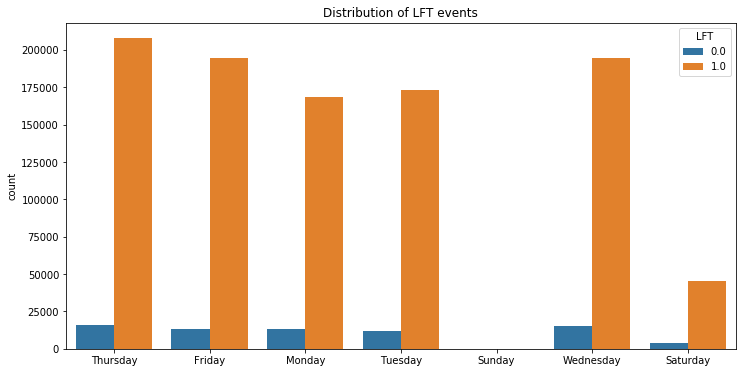

In [51]:
"""Visualization"""
#Distribution of LFT events
sns.countplot('weekday',data=df,hue='LFT')
plt.title('Distribution of LFT events')
plt.xlabel('')
plt.show()
## NOT LFT EVENTS FAIRLY CONSISTENT

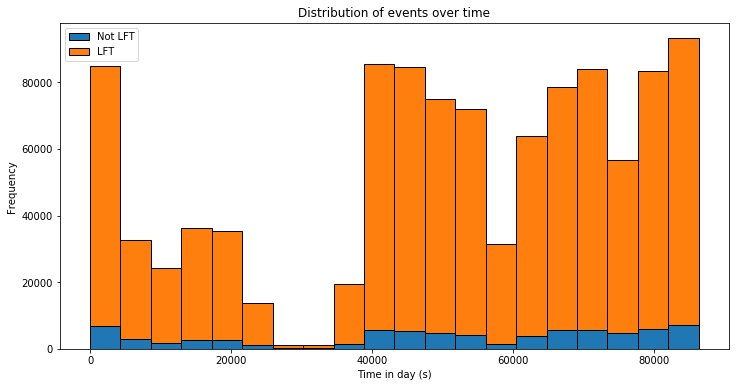

In [52]:
#Distribution of events over time
df[['time','LFT']].pivot(columns='LFT').plot(kind='hist',stacked=True,bins=20,ec='k')
plt.legend(['Not LFT','LFT'])
plt.title('Distribution of events over time')
plt.xlabel('Time in day (s)')
plt.show()

In [80]:
# PCA
weekday_dict = {day:n for day,n in zip(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],range(7))}
data_df = df[['time','height','width','length','volume','weight','angle','gap','velocity','weekday','LFT']]
data_df.weekday = data_df.weekday.apply(lambda x: weekday_dict[x])
data = np.array(data_df.dropna())

c:\users\michael\appdata\local\programs\python\python35\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [133]:
x = data[:,:-1]
labels = data[:,-1]
#Normalize
x_norm = (x-x.mean(axis=0))/x.std(axis=0)
#Calculate covariance
cov = np.cov(x_norm,rowvar=False)
#Calculate eigenvectors
[lam,v] = np.linalg.eig(cov)
#Take first two principal components
pcs = np.array(pd.DataFrame(np.hstack([lam.reshape(-1,1),v])).sort_values(by=0,ascending=False).iloc[:2,1:])


array([[-0.00249294,  0.00155897, -0.68606345,  0.00486746, -0.01787562,
        -0.10690993, -0.71447287,  0.02859842, -0.06669952,  0.04239286],
       [ 0.44154247,  0.25778994, -0.03748817, -0.72273641, -0.31609201,
         0.29888032, -0.01800317, -0.14936534,  0.02677406, -0.04729414]])

In [243]:
"""Analysis"""
# train_idx = np.floor(np.arange(0,len(train_df),len(train_df)/5)).astype(int)
# train_idx = list(train_idx)+[len(train_df)]
# train_sets = [train_df.iloc[train_idx[i]:train_idx[i+1]-1] for i in range(len(train_idx)-1)]

# test_idx = np.floor(np.arange(0,len(test_df),len(test_df)/5)).astype(int)
# test_idx = list(test_idx) + [len(test_df)]
# test_sets = [test_df.iloc[test_idx[i]:test_idx[i+1]-1] for i in range(len(test_idx)-1)]
shuffled = df.sample(frac=1,random_state=1234)

weekday_dict = {day:n for day,n in zip(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],range(7))}
cols = ['time','height','width','length','volume','weight','angle','gap','velocity','weekday','LFT']
shuffled = shuffled[cols]
shuffled.weekday = shuffled.weekday.apply(lambda x: weekday_dict[x])

idx = np.floor(np.arange(0,len(shuffled),len(shuffled)/5)).astype(int)
idx = list(idx)+[len(shuffled)]
sets = {i:shuffled.iloc[idx[i]:idx[i+1]-1] for i in range(len(idx)-1)}

In [ ]:
#Cross validation
acc = []
for i in range(len(sets)): 
    #Training set (leaving out current test set)
    train = pd.concat([sets[s] for s in range(len(sets)) if s!=i])
    train_data = train[cols]
    train_labels = train.LFT
    
    #Test set
    test = sets[i]
    test_data = test[cols]
    test_labels = test.LFT
    
    clf = svm.SVC().fit(train_data,train_labels)
    # Accuracy = (TP+TN)/total
    # Precision = TP/(TP+FP)
    # Recall = TP/(TP+FN)
    acc.append(clf.score(test_data,test_labels))

In [ ]:
acc